In [62]:
import sys
sys.path.append('..') # Add parent directory to path

import pandas as pd
import glob
import os
import requests
import time
import datetime
from weather.src.config import locations

In [15]:
files = glob.glob(
    os.path.join('ds', "*_weather.csv")
)

data = pd.DataFrame()
for ind, file in enumerate(files):
    df = pd.read_csv(file)
    df["resort"] = os.path.basename(file).split("_")[0]
    data = pd.concat([data, df])

data.head()

,date,temperature_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_100m,is_day,sunshine_duration,fetch_timestamp,request_file,resort
0,2024-02-01 00:00:00+00:00,-0.5195,-3.535757,0.0,0.0,0.0,1.37,0.000000,0.0,0.0,0.0,3.758510,0.0,0.0,2024-03-30 10:56:20.684646,laax_weather.csv,laax
1,2024-02-01 01:00:00+00:00,-1.1695,-4.503199,0.0,0.0,0.0,1.37,5.100000,0.0,0.0,17.0,7.091177,0.0,0.0,2024-03-30 10:56:20.684646,laax_weather.csv,laax
2,2024-02-01 02:00:00+00:00,-1.0695,-4.452381,0.0,0.0,0.0,1.37,22.500000,1.0,0.0,72.0,7.993297,0.0,0.0,2024-03-30 10:56:20.684646,laax_weather.csv,laax
3,2024-02-01 03:00:00+00:00,-1.2195,-4.383105,0.0,0.0,0.0,1.37,30.900000,2.0,0.0,97.0,4.198285,0.0,0.0,2024-03-30 10:56:20.684646,laax_weather.csv,laax
4,2024-02-01 04:00:00+00:00,-1.6195,-4.924282,0.0,0.0,0.0,1.37,31.800001,2.0,0.0,100.0,5.447788,0.0,0.0,2024-03-30 10:56:20.684646,laax_weather.csv,laax


### Augmentation
- add daylight duration
- add sunnyness (percentage of sunny hours of daylight hours)

/tmp/ipykernel_178784/1243952230.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_day = item.groupby("day").apply(calc_features)


            max_temp   min_temp  avg_temp   max_wind   min_wind   avg_wind  \
day                                                                          
2024-02-01    -0.875  -5.325000 -2.285417  11.298495   1.080000   5.742066   
2024-02-02     3.775  -7.375000 -1.325000   7.568566   0.360000   4.043848   
2024-02-03     6.575   0.825000  3.029167   6.369050   0.804984   3.718331   
2024-02-04     4.825  -0.225000  1.897917  10.703569   4.072935   6.360346   
2024-02-05     5.825  -0.375000  1.766667   9.007196   1.297998   5.022011   
2024-02-06     2.625  -2.975000 -0.370833  10.137692   4.610250   8.011047   
2024-02-07    -0.525  -9.275000 -4.058333  14.869351   4.198285   9.996787   
2024-02-08     1.725  -3.425000 -1.166667  20.111729  10.182337  14.607459   
2024-02-09     0.075  -3.325000 -1.947917  21.203358  14.264361  17.655626   
2024-02-10     0.125  -5.725000 -2.918750  21.638964   4.334974  15.117814   
2024-02-11    -2.425  -6.425000 -4.243750  13.281023   5.634891 

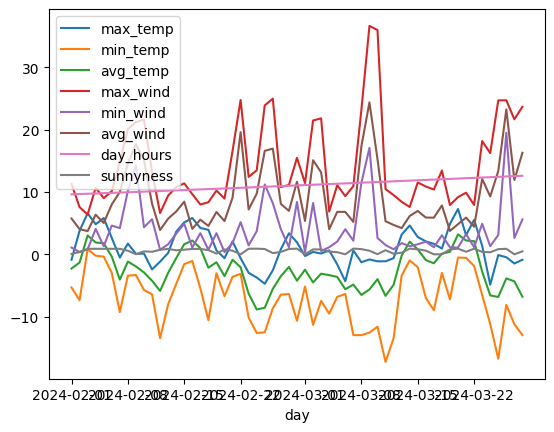

In [69]:
def calc_features(group):
    
    lat = [location["latitude"] for location in locations if location["short_name"] == group["resort"].iloc[0]][0]
    long = [location["longitude"] for location in locations if location["short_name"] == group["resort"].iloc[0]][0]
    date = group["date"].iloc[0]
    response = requests.get(f"https://api.sunrisesunset.io/json?lat={lat}&lng={long}&date={date}").json()
    tt = time.strptime(response["results"]["day_length"],'%H:%M:%S')
    daylight_seconds = datetime.timedelta(hours=tt.tm_hour,minutes=tt.tm_min,seconds=tt.tm_sec).total_seconds()

    d = {}
    d["max_temp"] = group["temperature_2m"].max()
    d["min_temp"] = group["temperature_2m"].min()
    d["avg_temp"] = group["temperature_2m"].mean()
    #d["avg_temp2"] = (group["temperature_2m"].max() + group["temperature_2m"].min()) / 2
    d["max_wind"] = group["wind_speed_100m"].max()
    d["min_wind"] = group["wind_speed_100m"].min()
    d["avg_wind"] = group["wind_speed_100m"].mean()

    d["day_hours"] = daylight_seconds / 3600
    d["sunnyness"] = group[group['is_day'] > 0]["sunshine_duration"].sum() / daylight_seconds
    return pd.Series(d)

for ind, (key, item) in enumerate(data.groupby("resort")):
    if ind > 0:
        break

    item["day"] = pd.to_datetime(item["date"]).apply(lambda x: x.date())
    by_day = item.groupby("day").apply(calc_features)
    print(by_day)

    by_day.plot()